# Energy Consumption
To better follow the energy consumption, the government wants energy suppliers to install smart meters in every home in England, Wales and Scotland. There are more than 26 million homes for the energy suppliers to get to, with the goal of every home having a smart meter by 2020.

This roll out of meter is lead by the European Union who asked all member governments to look at smart meters as part of measures to upgrade our energy supply and tackle climate change. After an initial study, the British government decided to adopt smart meters as part of their plan to update our ageing energy system.

In this dataset, you will find a refactorised version of the data from the London data store, that contains the energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014. The data from the smart meters seems associated only to the electrical consumption.

**Approach : **

1.  Combine all blocks into a single dataframe- keeping on relevant columns.
2. Use day-level energy consumption data per household to normalize data for inconsistent household count
3. Explore relationships between weather conditions and energy consumptions. Create clusters for the weather data- using which we can add weather identifiers to day-level data
4. Add UK holidays data to the day level data as an indicator.
5. Fit an ARIMA model
        i) ACF, PACF
        ii) Explore Seasonal Decomposition
        iii) Modelling 
7. Fit an LSTM model

# Daily Energy Data Preparation

**Importing Libraries **

In [ ]:
#!pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
import os

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot

#from pyramid.arima import auto_arima
#from pmdarima.arima import auto_arima
import pyflux as pf
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Conv1D


ModuleNotFoundError: No module named 'matplotlib'

### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [2]:
# Combining all blocks
for num in range(0,112):
    df = pd.read_csv("../input/daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

** Energy at Day Level **

In [3]:
energy = pd.read_csv('energy.csv')
len(energy)

3536007

In [4]:
energy.head()

,Unnamed: 0,day,LCLid,energy_sum
0,0,2012-10-12,MAC000002,7.098
1,1,2012-10-13,MAC000002,11.087
2,2,2012-10-14,MAC000002,13.223
3,3,2012-10-15,MAC000002,10.257
4,4,2012-10-16,MAC000002,9.769


**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [5]:
housecount = energy.groupby('day')[['LCLid']].nunique()
print(len(housecount))
housecount.head(4)

829


,LCLid
day,
2011-11-23,13
2011-11-24,25
2011-11-25,32
2011-11-26,41


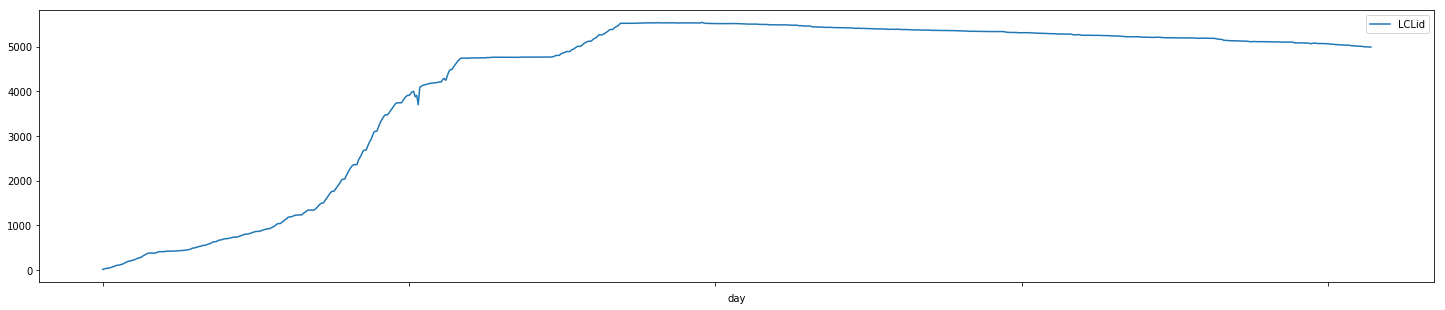

In [6]:
housecount.plot(figsize=(25,5))

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [7]:
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

In [8]:
energy.count()

day           829
energy_sum    829
LCLid         829
dtype: int64

In [9]:
energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date

In [10]:
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']
print("Starting Point of Data at Day Level",min(energy.day))
print("Ending Point of Data at Day Level",max(energy.day))

Starting Point of Data at Day Level 2011-11-23
Ending Point of Data at Day Level 2014-02-28


In [11]:
energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [12]:
weather = pd.read_csv('../input/weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureMax,uvIndex,time,sunsetTime,temperatureLow,temperatureMin,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,10.87,rain,3.30,0.95,2011-11-11 19:00:00,10.87,11.96,1.0,2011-11-11 00:00:00,2011-11-11 16:19:21,10.87,8.85,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,5.62,rain,12.09,0.88,2011-12-11 19:00:00,-0.64,5.72,1.0,2011-12-11 00:00:00,2011-12-11 15:52:53,3.09,2.48,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,10.33,rain,13.39,0.74,2011-12-27 14:00:00,5.52,10.33,0.0,2011-12-27 00:00:00,2011-12-27 15:57:56,8.03,8.03,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,5.33,rain,11.89,0.87,2011-12-02 12:00:00,3.26,5.33,1.0,2011-12-02 00:00:00,2011-12-02 15:56:17,6.33,2.56,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [13]:
weather.describe()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
count,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,881.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,13.660113,195.702948,6.530034,0.477605,3.581803,1014.127540,12.723866,11.167143,0.781871,6.085045,12.929467,2.542565,7.709841,7.414161,13.542392,5.738039,0.500930
std,6.182744,89.340783,4.830875,0.193514,1.694007,11.073038,7.279168,2.466109,0.095348,6.031967,7.105426,1.832985,4.871004,4.888852,6.260196,6.048746,0.287022
min,-0.060000,0.000000,-7.840000,0.000000,0.200000,979.250000,-6.460000,1.480000,0.430000,-8.880000,-4.110000,0.000000,-5.640000,-5.640000,-0.810000,-8.880000,0.000000
25%,9.502500,120.500000,3.180000,0.350000,2.370000,1007.435000,7.032500,10.327500,0.720000,1.522500,7.332500,1.000000,3.990000,3.705000,9.212500,1.105000,0.260000
50%,12.625000,219.000000,6.380000,0.470000,3.440000,1014.615000,12.470000,11.970000,0.790000,5.315000,12.625000,2.000000,7.540000,7.100000,12.470000,4.885000,0.500000
75%,17.920000,255.000000,10.057500,0.600000,4.577500,1021.755000,17.910000,12.830000,0.860000,11.467500,17.920000,4.000000,11.467500,11.277500,17.910000,11.277500,0.750000
max,32.400000,359.000000,17.770000,1.000000,9.960000,1040.920000,32.420000,15.340000,0.980000,20.540000,32.420000,7.000000,20.540000,20.540000,32.400000,20.540000,0.990000


In [14]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

### Relationship of weather conditions with electricity consumption

In [15]:
weather_energy =  energy.merge(weather,on='day')
weather_energy.head(2)

,day,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase
0,2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,8.06,0.93,6.56,10.36,1.0,8.24,3.81,10.36,2.18,0.94
1,2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,10.64,0.89,7.30,12.93,1.0,9.71,8.56,12.93,7.01,0.97


 *** 1. Temperature ***
> We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases. 

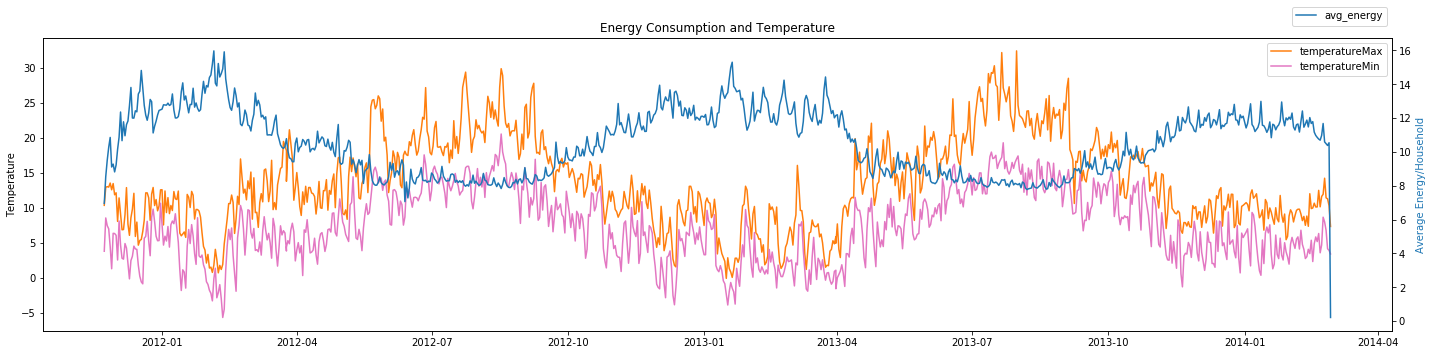

In [16]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


***2.  Humidity ***

>  Humidity and the average consumption of energy seems to have the same trend.


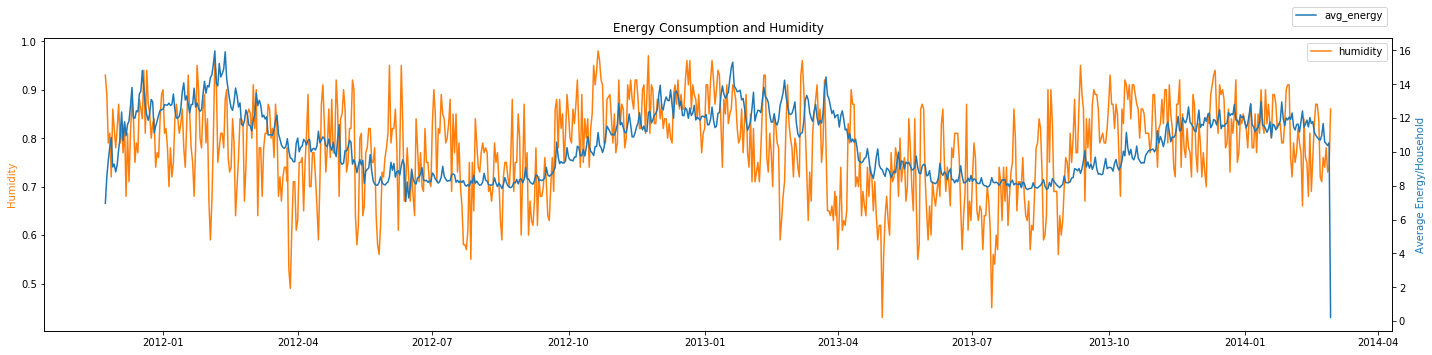

In [17]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

***3. Cloud Cover***
> The cloud cover value seems to be following the same pattern as the energy consumption.

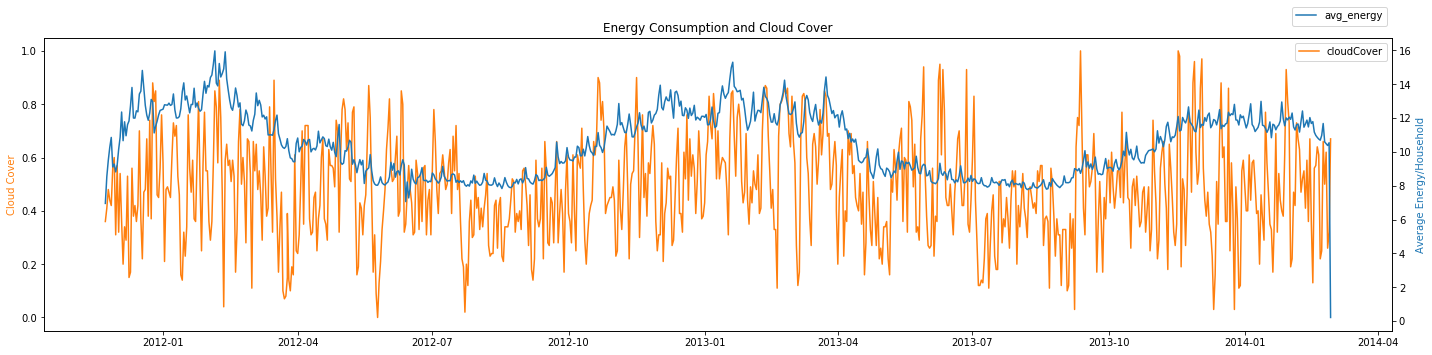

In [18]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

***4. Visibility***
> The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

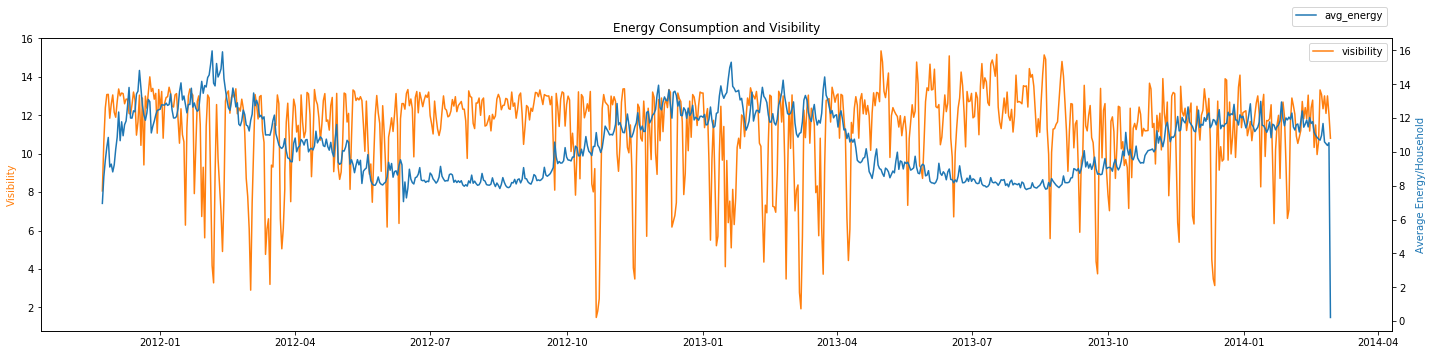

In [19]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

***5.  Wind Speed***
>  Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

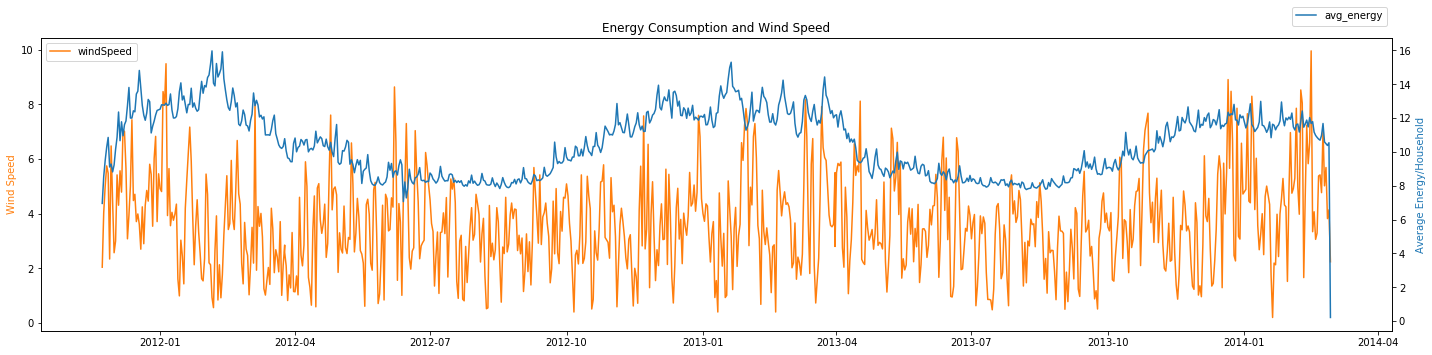

In [20]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

***6.  UV Index***
> The UV index has an inverse relationship with energy consumption- why?

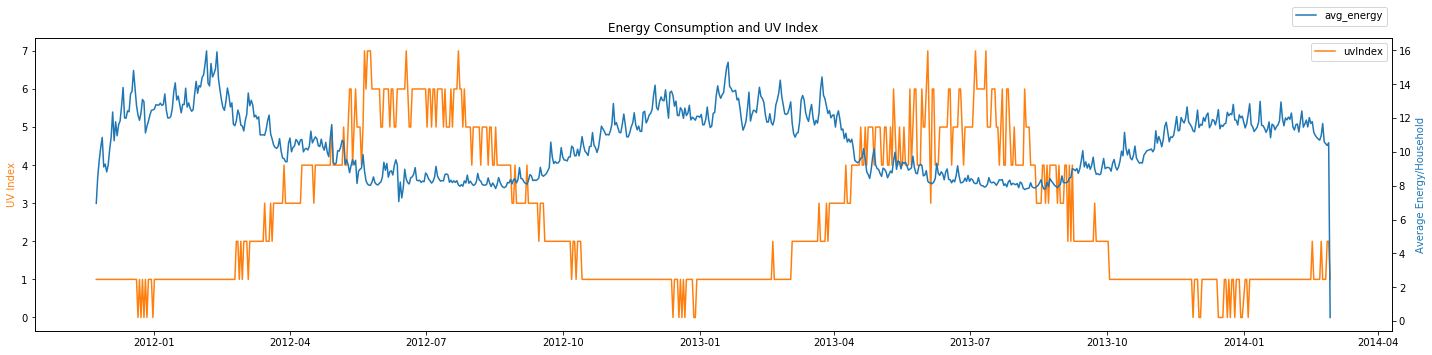

In [21]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

***7. dewPoint***
> Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

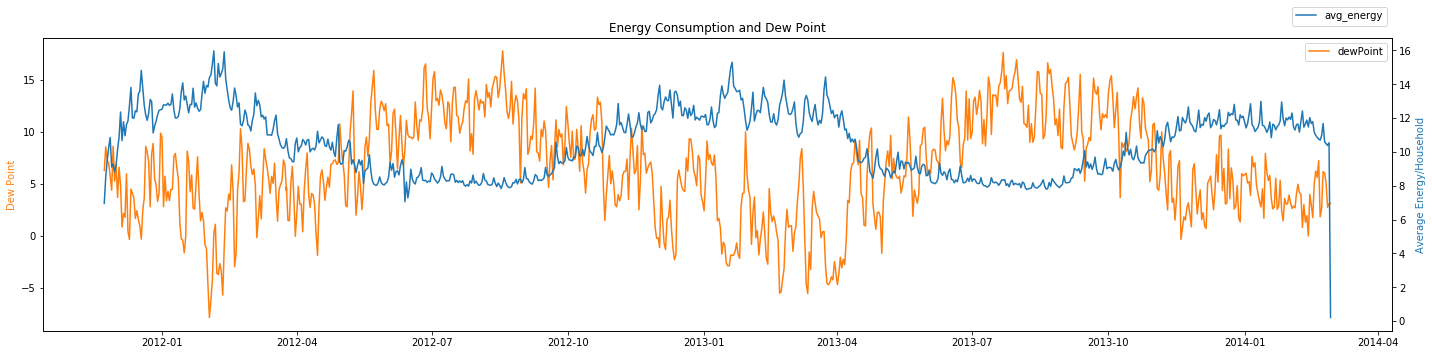

In [22]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:blue')
ax2.set_ylabel('Average Energy/Household',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### Correlation between Weather Variables and Energy Consumption
* Energy has high positive correlation with humidity and high negative correlation with temperature.
* Dew Point, UV Index display multicollinearity with Temperature, hence discarded
* Cloud Cover and Visibility display multicollinearity with Humidity, hence discarded
* Pressure and Moon Phase have minimal correlation with Energy, hence discarded
* Wind Speed has low correlation with energy but does not show multicollinearity


In [23]:
cor_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,avg_energy,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
avg_energy,1.000000,-0.846965,-0.755901,0.241779,0.149624,-0.028851,-0.246404,0.361237,-0.733171,-0.031716
temperatureMax,-0.846965,1.000000,0.865038,-0.333409,-0.153602,0.118933,0.259108,-0.404899,0.696497,0.003636
dewPoint,-0.755901,0.865038,1.000000,-0.025207,-0.092212,-0.028121,0.042633,0.055514,0.486692,-0.008239
cloudCover,0.241779,-0.333409,-0.025207,1.000000,0.170235,-0.101079,-0.330177,0.480056,-0.248695,-0.062126
windSpeed,0.149624,-0.153602,-0.092212,0.170235,1.000000,-0.344354,0.281088,-0.042391,-0.152634,-0.023273
pressure,-0.028851,0.118933,-0.028121,-0.101079,-0.344354,1.000000,-0.012508,-0.250941,0.100774,0.038462
visibility,-0.246404,0.259108,0.042633,-0.330177,0.281088,-0.012508,1.000000,-0.578130,0.240485,0.062813
humidity,0.361237,-0.404899,0.055514,0.480056,-0.042391,-0.250941,-0.578130,1.000000,-0.533919,-0.013997
uvIndex,-0.733171,0.696497,0.486692,-0.248695,-0.152634,0.100774,0.240485,-0.533919,1.000000,0.012833
moonPhase,-0.031716,0.003636,-0.008239,-0.062126,-0.023273,0.038462,0.062813,-0.013997,0.012833,1.000000


### Creating Weather Clusters 
> The weather information has a lot of variables- which might not all be useful. We will attempt to create weather clusters to see if we can define a weather of the day based on the granular weather data like temperature, precipitation etc. 

In [24]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])

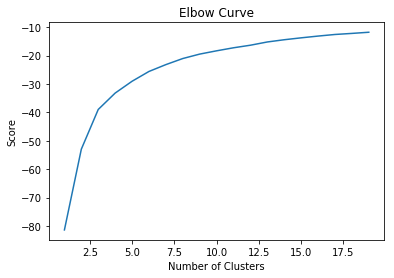

In [25]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [26]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

In [31]:
weather_energy['weather_cluster'][:10]

0    1
1    1
2    2
3    2
4    2
5    1
6    2
7    2
8    1
9    1
Name: weather_cluster, dtype: int32

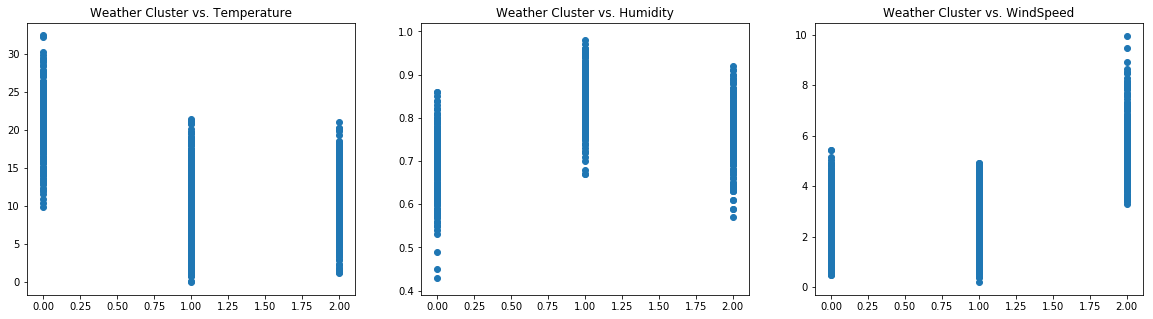

In [27]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)
plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)
plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()
# put this in a loop

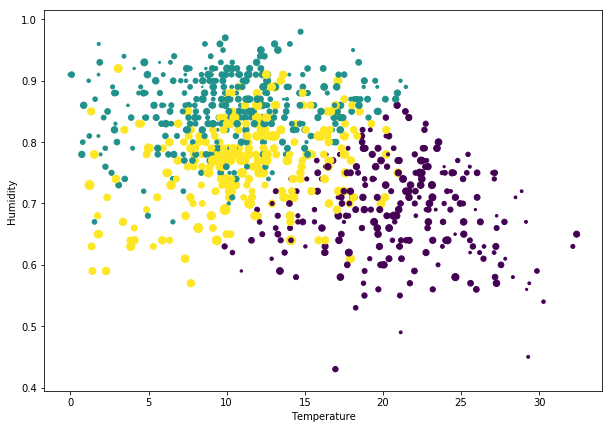

In [32]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity, 
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

### UK Bank Holidays

In [33]:
holiday = pd.read_csv('../input/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date
holiday

,Bank holidays,Type
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)
5,2012-07-05,Early May bank holiday
6,2012-09-04,Easter Monday
7,2012-06-04,Good Friday
8,2012-02-01,New Year?s Day (substitute day)
9,2013-12-26,Boxing Day


**Creating a holiday indicator on weather data**

In [34]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

### ARIMAX

In [35]:
weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

** Subset for required columns and 70-30 train-test split**

In [36]:
model_data = weather_energy[['avg_energy','weather_cluster','holiday_ind']]
# train = model_data.iloc[0:round(len(model_data)*0.90)]
# test = model_data.iloc[len(train)-1:]
train = model_data.iloc[0:(len(model_data)-30)]
test = model_data.iloc[len(train):(len(model_data)-1)]

In [39]:
len(test)

29

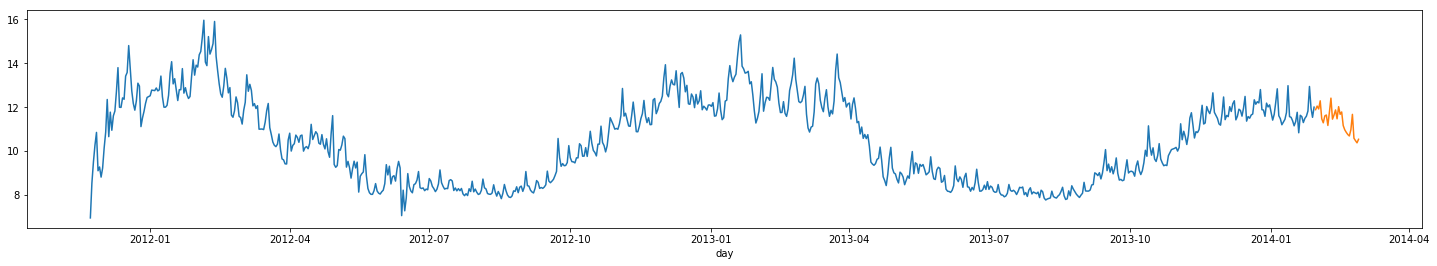

In [40]:
train['avg_energy'].plot(figsize=(25,4))
test['avg_energy'].plot(figsize=(25,4))


In [42]:
test.head()

,avg_energy,weather_cluster,holiday_ind
day,,,
2014-01-30,11.886982,1,0
2014-01-31,12.051321,1,0
2014-02-01,11.921217,2,0
2014-02-02,12.291726,2,0
2014-02-03,11.471760,2,0


**ACF PACF **

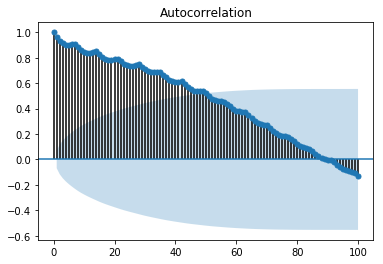

In [43]:
plot_acf(train.avg_energy,lags=100)
plt.show()

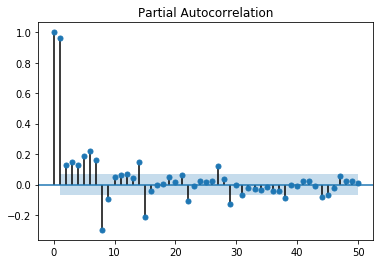

In [44]:
plot_pacf(train.avg_energy,lags=50)
plt.show()

Autocorrelation plot shows gradual decay while Partial AutoCorrelation shows that there is a sharp drop after 1st lag. This means that most of the higher-order autocorrelations are effectively explained by the k = 1 lag. Therefore, the series displays AR 'signature' 

**Dickey Fuller's Test**
> p is greater than 0.05 therefore the data is not stationary. After differencing, p < 0.05.

In [45]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.872794
p-value                          0.344966
#Lags Used                      21.000000
Number of Observations Used    776.000000
dtype: float64

In [46]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [47]:
t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                -6.715004e+00
p-value                        3.600554e-09
#Lags Used                     2.000000e+01
Number of Observations Used    7.760000e+02
dtype: float64

**Seasonal Decomposition**
> The seasonal component is quite low while the trend is quite strong with obvious dips in electricity consumption during summers i.e. April to September. This may be attributed to longer days during summer.

In [48]:
s = sm.tsa.seasonal_decompose(train.avg_energy,freq=12)

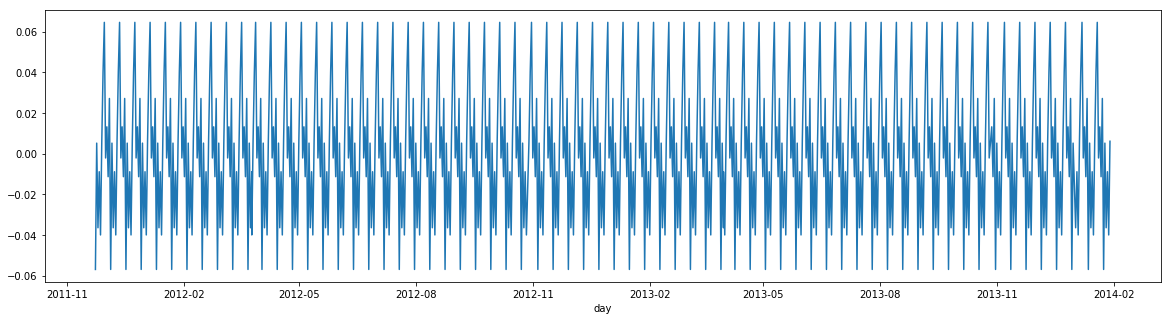

In [49]:
s.seasonal.plot(figsize=(20,5))

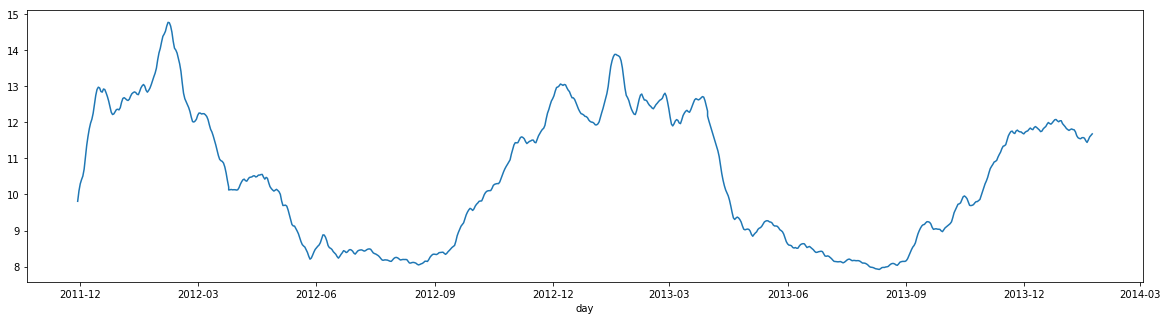

In [50]:
s.trend.plot(figsize=(20,5))

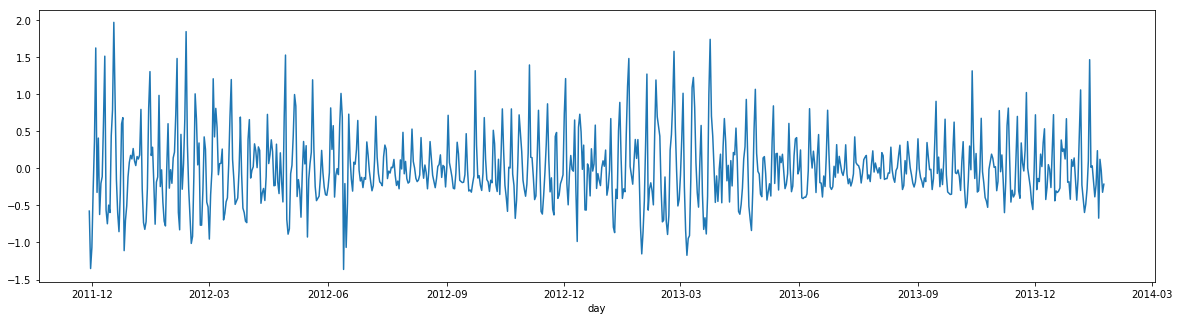

In [51]:
s.resid.plot(figsize=(20,5))

In [52]:
endog = train['avg_energy']
exog = sm.add_constant(train[['weather_cluster','holiday_ind']])

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7,1,1),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         avg_energy   No. Observations:                  798
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -649.430
Date:                            Wed, 09 Dec 2020   AIC                           1326.860
Time:                                    08:27:29   BIC                           1392.180
Sample:                                         0   HQIC                          1351.975
                                            - 798                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0064      0.017     -0.378      0.705      -0.039       0.027
const           -3.096e-08   4.78e-10    -64.830      0.000   -3.19e-08      -3e-08
weather_cluster    -0.0007      0.025     -0.030      0.976      -0.049       0.048
holiday_ind        -0.0344      0.088     -0.391      0.696      -0.207       0.138
ar.L1              -0.0009      0.087     -0.010      0.992      -0.171       0.169
ar.L2              -0.1547      0.032     -4.854      0.000      -0.217      -0.092
ar.L3              -0.1431      0.039     -3.714      0.000      -0.219      -0.068
ar.L4              -0.1512      0.038     -3.983      0.000      -0.226      -0.077
ar.L5              -0.1631      0.040     -4.084      0.000      -0.241      -0.085
ar.L6               0.0087      0.036      0.238      0.812      -0.063       0.080
ar.L7               0.3527      0.028     12.378      0.000       0.297       0.409
ma.L1              -0.1855      0.092     -2.028      0.043      -0.365      -0.006
ar.S.L12           -0.4832      0.033    -14.823      0.000      -0.547      -0.419
sigma2              0.3041      0.013     24.045      0.000       0.279       0.329
===================================================================================
Ljung-Box (Q):                      221.16   Jarque-Bera (JB):                45.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+16. Standard errors may be unstable.
"""

**Model Fit**

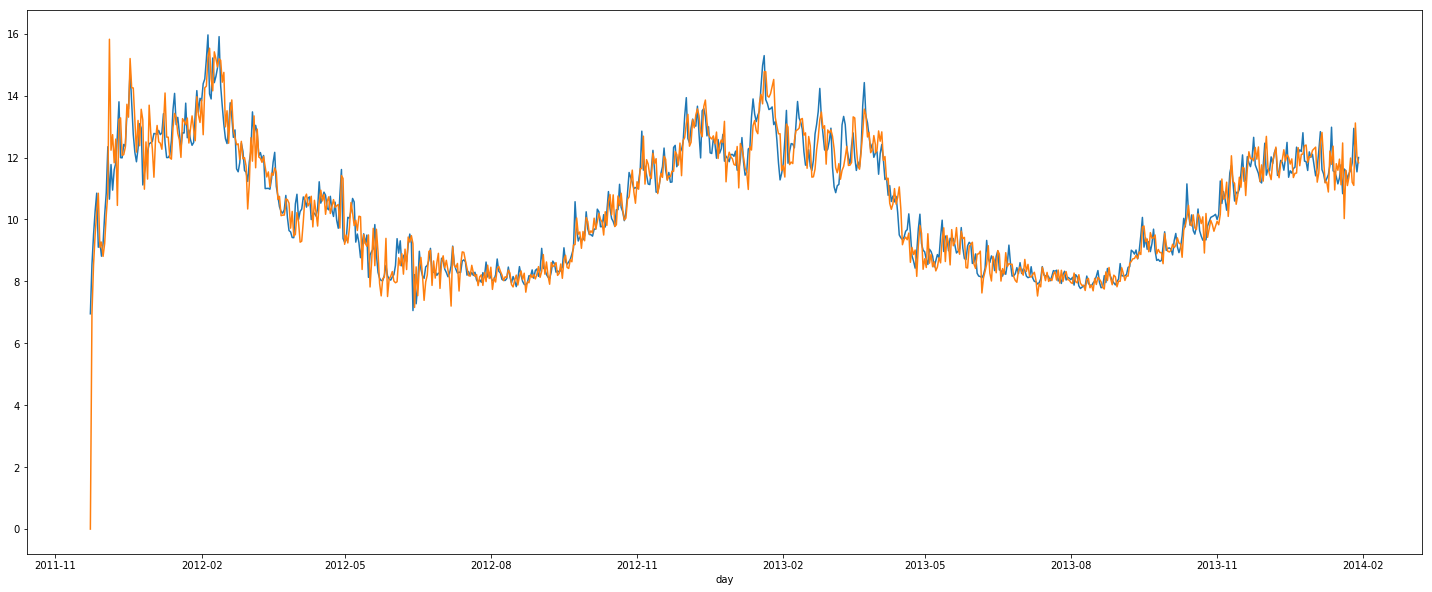

In [53]:
train['avg_energy'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

**Prediction**

In [54]:
predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster','holiday_ind']]))
test['predicted'] = predict.values
test.tail(5)

,avg_energy,weather_cluster,holiday_ind,predicted
day,,,,
2014-02-23,11.673756,2,0,11.557967
2014-02-24,10.586235,2,0,10.708768
2014-02-25,10.476498,2,0,11.446683
2014-02-26,10.375366,2,0,11.870747
2014-02-27,10.537250,2,0,11.484926


In [55]:
test['residual'] = abs(test['avg_energy']-test['predicted'])
MAE = test['residual'].sum()/len(test)
MAPE = (abs(test['residual'])/test['avg_energy']).sum()*100/len(test)
print("MAE:", MAE)
print("MAPE:", MAPE)

MAE: 0.585502020372114
MAPE: 5.240429745996292


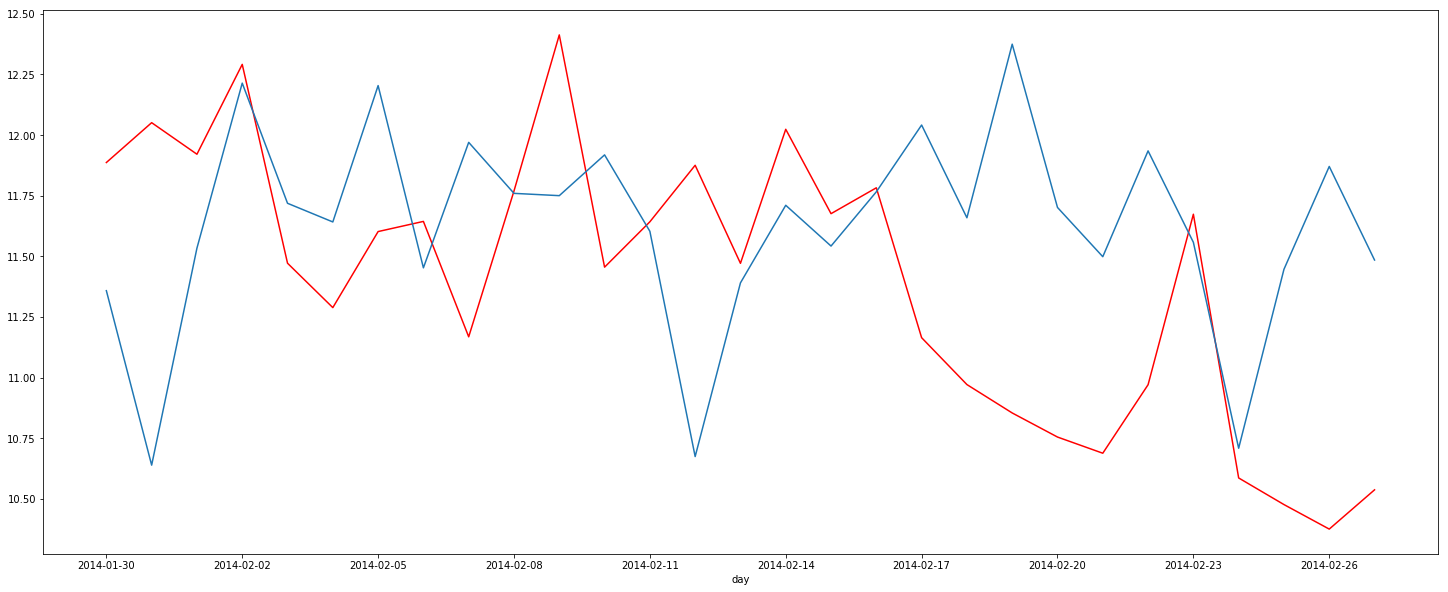

In [56]:
test['avg_energy'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

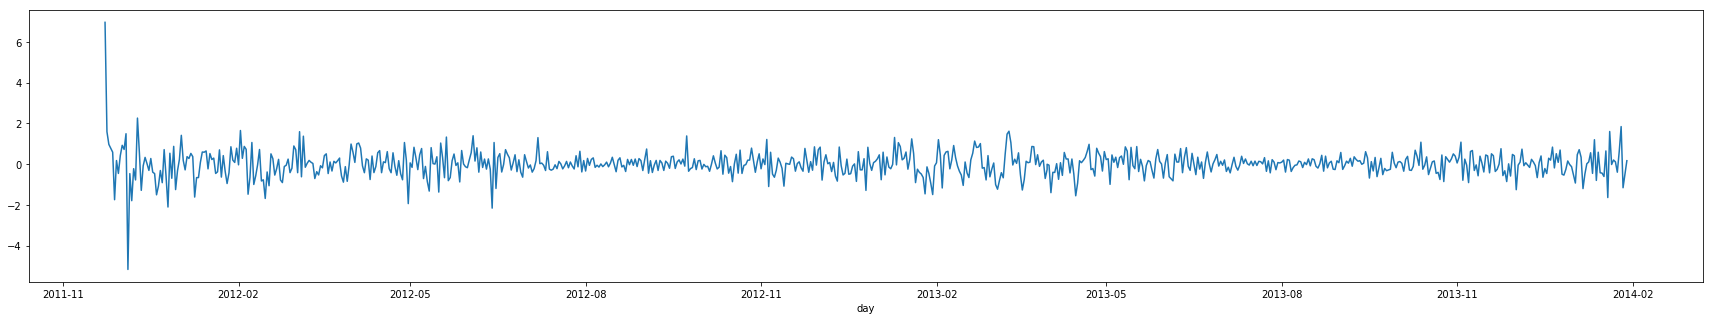

In [57]:
model_fit.resid.plot(figsize= (30,5))

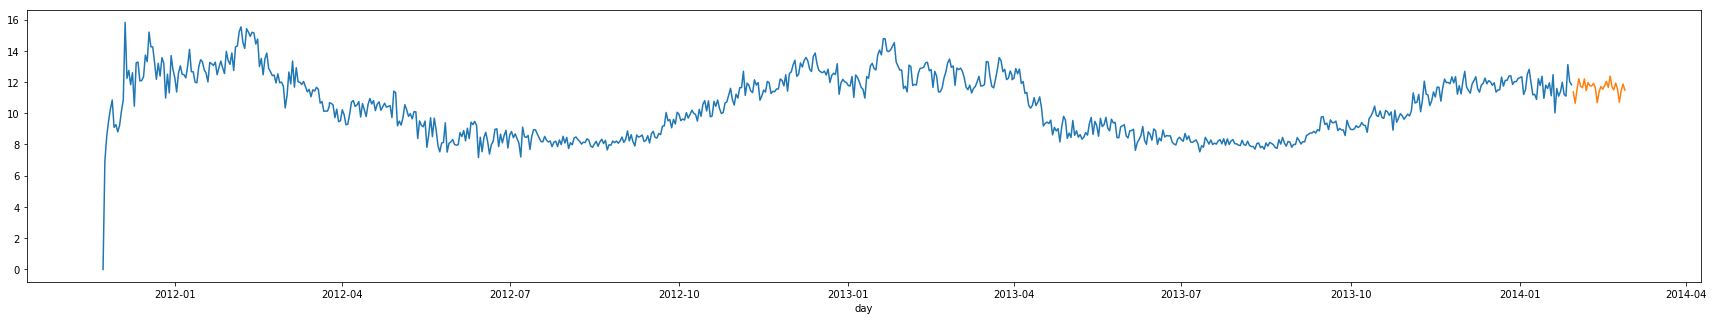

In [58]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [59]:
test['predicted'].tail(5)

day
2014-02-23    11.557967
2014-02-24    10.708768
2014-02-25    11.446683
2014-02-26    11.870747
2014-02-27    11.484926
Name: predicted, dtype: float64

In [60]:
# only ARIMA

In [61]:
from pandas.plotting import autocorrelation_plot

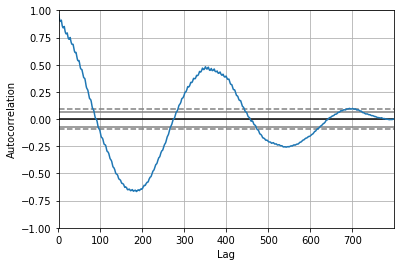

In [63]:
autocorrelation_plot(train.avg_energy)
plt.show()

In [64]:
from statsmodels.tsa.arima_model import ARIMA

                             ARIMA Model Results                              
Dep. Variable:           D.avg_energy   No. Observations:                  797
Model:                 ARIMA(7, 1, 1)   Log Likelihood                -501.378
Method:                       css-mle   S.D. of innovations              0.453
Date:                Wed, 09 Dec 2020   AIC                           1022.757
Time:                        08:33:58   BIC                           1069.565
Sample:                             1   HQIC                          1040.742
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0051      0.010      0.492      0.623      -0.015       0.026
ar.L1.D.avg_energy    -0.0568      0.081     -0.702      0.483      -0.215       0.102
ar.L2.D.avg_energy  

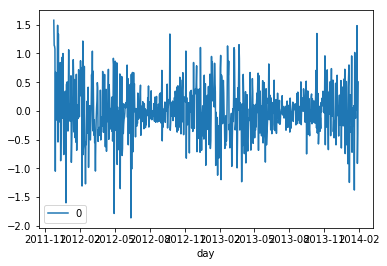

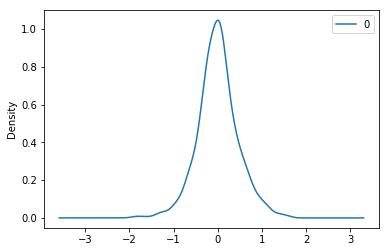

                0
count  797.000000
mean     0.002244
std      0.456113
min     -1.864423
25%     -0.256295
50%      0.002937
75%      0.242171
max      1.578661


In [65]:
# fit model
model = ARIMA(train.avg_energy, order=(7,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [85]:
predictions = list()
history = train.avg_energy.values.tolist()
for t in range(len(test)):
	model = ARIMA(history, order=(7,1,1))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat[0])
	obs = test.avg_energy[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=11.948379, expected=11.886982
predicted=11.902721, expected=12.051321
predicted=12.246460, expected=11.921217
predicted=12.384200, expected=12.291726
predicted=11.907967, expected=11.471760
predicted=11.401525, expected=11.288728
predicted=11.555210, expected=11.602300
predicted=11.630230, expected=11.644153
predicted=11.745138, expected=11.168278
predicted=11.346293, expected=11.769625
predicted=11.856777, expected=12.413253
predicted=11.923058, expected=11.455522
predicted=11.423029, expected=11.642560
predicted=11.756692, expected=11.875646
predicted=11.779630, expected=11.471329
predicted=11.359770, expected=12.024045
predicted=12.226122, expected=11.676097
predicted=11.947843, expected=11.782755
predicted=11.483035, expected=11.164673
predicted=11.330049, expected=10.971368
predicted=11.186236, expected=10.854245
predicted=10.907054, expected=10.754953
predicted=11.103671, expected=10.688234
predicted=10.787512, expected=10.970704
predicted=11.039679, expected=11.673756


In [86]:
test['predicted_arima'] = predictions

In [87]:
test.head()

,avg_energy,weather_cluster,holiday_ind,predicted,residual,predicted_arima
day,,,,,,
2014-01-30,11.886982,1,0,11.358535,0.528448,11.948379
2014-01-31,12.051321,1,0,10.639090,1.412231,11.902721
2014-02-01,11.921217,2,0,11.534005,0.387212,12.246460
2014-02-02,12.291726,2,0,12.214396,0.077330,12.384200
2014-02-03,11.471760,2,0,11.718926,0.247166,11.907967


In [88]:
from sklearn.metrics import mean_absolute_error

In [90]:
error_sarimax = mean_absolute_error(test.avg_energy,test.predicted)
error_arima = mean_absolute_error(test.avg_energy,test.predicted_arima)
print(error_sarimax,error_arima)

0.585502020372114 0.3047943068202372


### LSTM

Using lags of upto 7 days we are going to convert this into a supervised problem. I have taken the function to create lags from this [tutorial](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) by Jason Brownlee. He has also applied the same to convert multivariate data to a supervised dataframe which he has in turn applied LSTM on.

In [91]:
np.random.seed(11)
dataframe = weather_energy.loc[:,'avg_energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [92]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [93]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,6.952693,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513
8,8.536480,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707
9,9.499782,10.267707,10.850805,9.103382,9.274873,8.813513,9.227707,10.145910


In [94]:
reframed['weather_cluster'] = weather_energy.weather_cluster.values[7:]
reframed['holiday_ind']= weather_energy.holiday_ind.values[7:]

In [95]:
reframed = reframed.reindex(['weather_cluster', 'holiday_ind','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

**Normalization**

In [96]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [122]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [123]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [124]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(791, 1, 9) (791,) (30, 1, 9) (30,)


**Modelling**

Epoch 1/50
 - 1s - loss: 0.5403
Epoch 2/50
 - 0s - loss: 0.4163
Epoch 3/50
 - 0s - loss: 0.2806
Epoch 4/50
 - 0s - loss: 0.1460
Epoch 5/50
 - 0s - loss: 0.1222
Epoch 6/50
 - 0s - loss: 0.1170
Epoch 7/50
 - 0s - loss: 0.1057
Epoch 8/50
 - 0s - loss: 0.0985
Epoch 9/50
 - 0s - loss: 0.0916
Epoch 10/50
 - 0s - loss: 0.0856
Epoch 11/50
 - 0s - loss: 0.0793
Epoch 12/50
 - 0s - loss: 0.0729
Epoch 13/50
 - 0s - loss: 0.0667
Epoch 14/50
 - 0s - loss: 0.0606
Epoch 15/50
 - 0s - loss: 0.0546
Epoch 16/50
 - 0s - loss: 0.0489
Epoch 17/50
 - 0s - loss: 0.0434
Epoch 18/50
 - 0s - loss: 0.0383
Epoch 19/50
 - 0s - loss: 0.0338
Epoch 20/50
 - 0s - loss: 0.0301
Epoch 21/50
 - 0s - loss: 0.0274
Epoch 22/50
 - 0s - loss: 0.0259
Epoch 23/50
 - 0s - loss: 0.0257
Epoch 24/50
 - 0s - loss: 0.0256
Epoch 25/50
 - 0s - loss: 0.0256
Epoch 26/50
 - 0s - loss: 0.0254
Epoch 27/50
 - 0s - loss: 0.0253
Epoch 28/50
 - 0s - loss: 0.0251
Epoch 29/50
 - 0s - loss: 0.0251
Epoch 30/50
 - 0s - loss: 0.0249
Epoch 31/50
 - 0s -

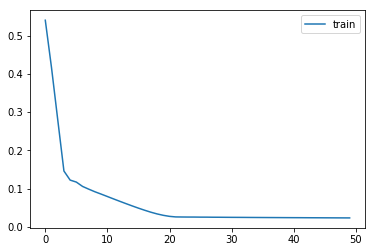

In [102]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

**Prediction**

In [103]:
# make a prediction
yhat = model.predict(test_X)

In [104]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [105]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [106]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

**Performance**

In [107]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


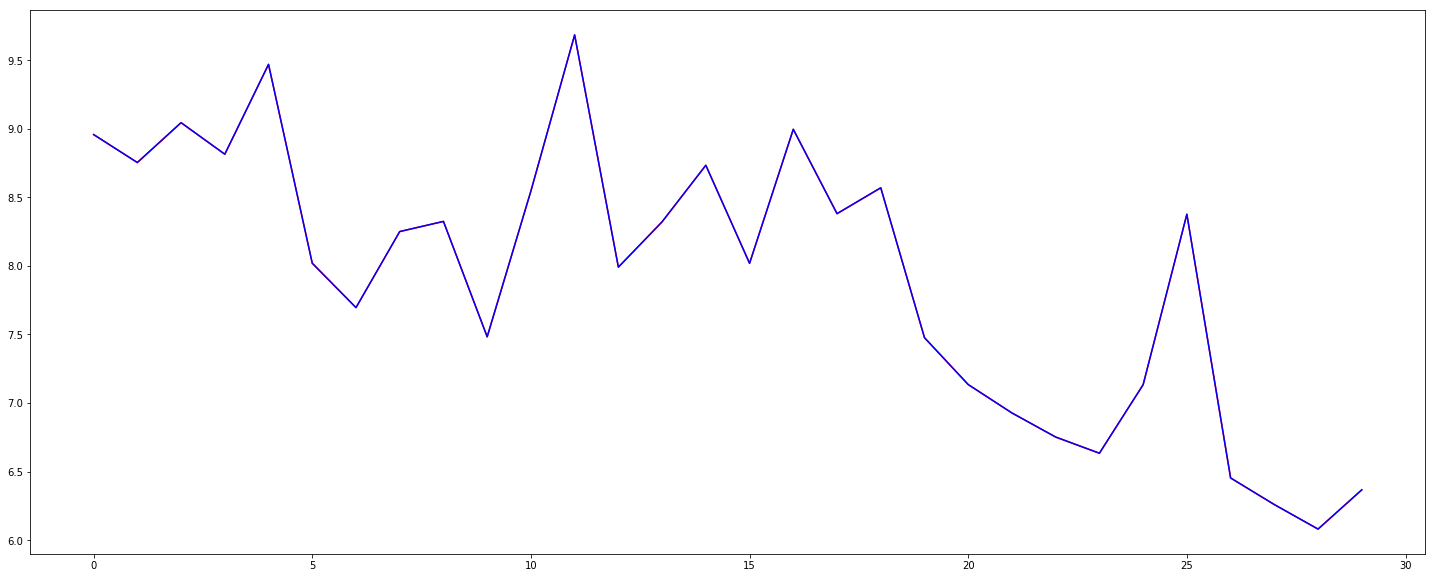

In [108]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

Epoch 1/50
 - 1s - loss: 0.5680
Epoch 2/50
 - 0s - loss: 0.3965
Epoch 3/50
 - 0s - loss: 0.1588
Epoch 4/50
 - 0s - loss: 0.1298
Epoch 5/50
 - 0s - loss: 0.0952
Epoch 6/50
 - 0s - loss: 0.0770
Epoch 7/50
 - 0s - loss: 0.0656
Epoch 8/50
 - 0s - loss: 0.0512
Epoch 9/50
 - 0s - loss: 0.0402
Epoch 10/50
 - 0s - loss: 0.0315
Epoch 11/50
 - 0s - loss: 0.0286
Epoch 12/50
 - 0s - loss: 0.0270
Epoch 13/50
 - 0s - loss: 0.0259
Epoch 14/50
 - 0s - loss: 0.0250
Epoch 15/50
 - 0s - loss: 0.0246
Epoch 16/50
 - 0s - loss: 0.0248
Epoch 17/50
 - 0s - loss: 0.0244
Epoch 18/50
 - 0s - loss: 0.0240
Epoch 19/50
 - 0s - loss: 0.0240
Epoch 20/50
 - 0s - loss: 0.0238
Epoch 21/50
 - 0s - loss: 0.0238
Epoch 22/50
 - 0s - loss: 0.0235
Epoch 23/50
 - 0s - loss: 0.0235
Epoch 24/50
 - 0s - loss: 0.0235
Epoch 25/50
 - 0s - loss: 0.0234
Epoch 26/50
 - 0s - loss: 0.0232
Epoch 27/50
 - 0s - loss: 0.0231
Epoch 28/50
 - 0s - loss: 0.0231
Epoch 29/50
 - 0s - loss: 0.0232
Epoch 30/50
 - 0s - loss: 0.0236
Epoch 31/50
 - 0s -

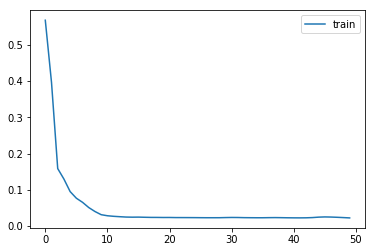

In [112]:
# design network
model = Sequential()
model.add(Conv1D(filters=50, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [125]:
test_X.shape

(30, 1, 9)

In [ ]:
yhat = model.predict(test_X)